# Heat equation - Retrieving operator through ODE solving

In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchdyn.core import NeuralODE
from torchdiffeq import odeint_adjoint

In [2]:
from utils.graphic_tools import simple_plotter, show_state, show_err, animate_plot, visualize_u_from_F, double_plotter
from utils.analysis_tools import relative_err, rmse, check_weights, downsampling
from utils.models import HeatModel

from equations.heat import get_heat, get_heat_grad_t, get_heat_fd, get_heat_fd_impl, get_heat_fft
from equations.initial_functions import random_init, high_dim_random_init, heat_analytical_init

from generators import heat_snapshot_generator, get_heat_batch
from training_dataset import generate_heat_training_dataset, read_dataset

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

<IPython.core.display.Javascript object>


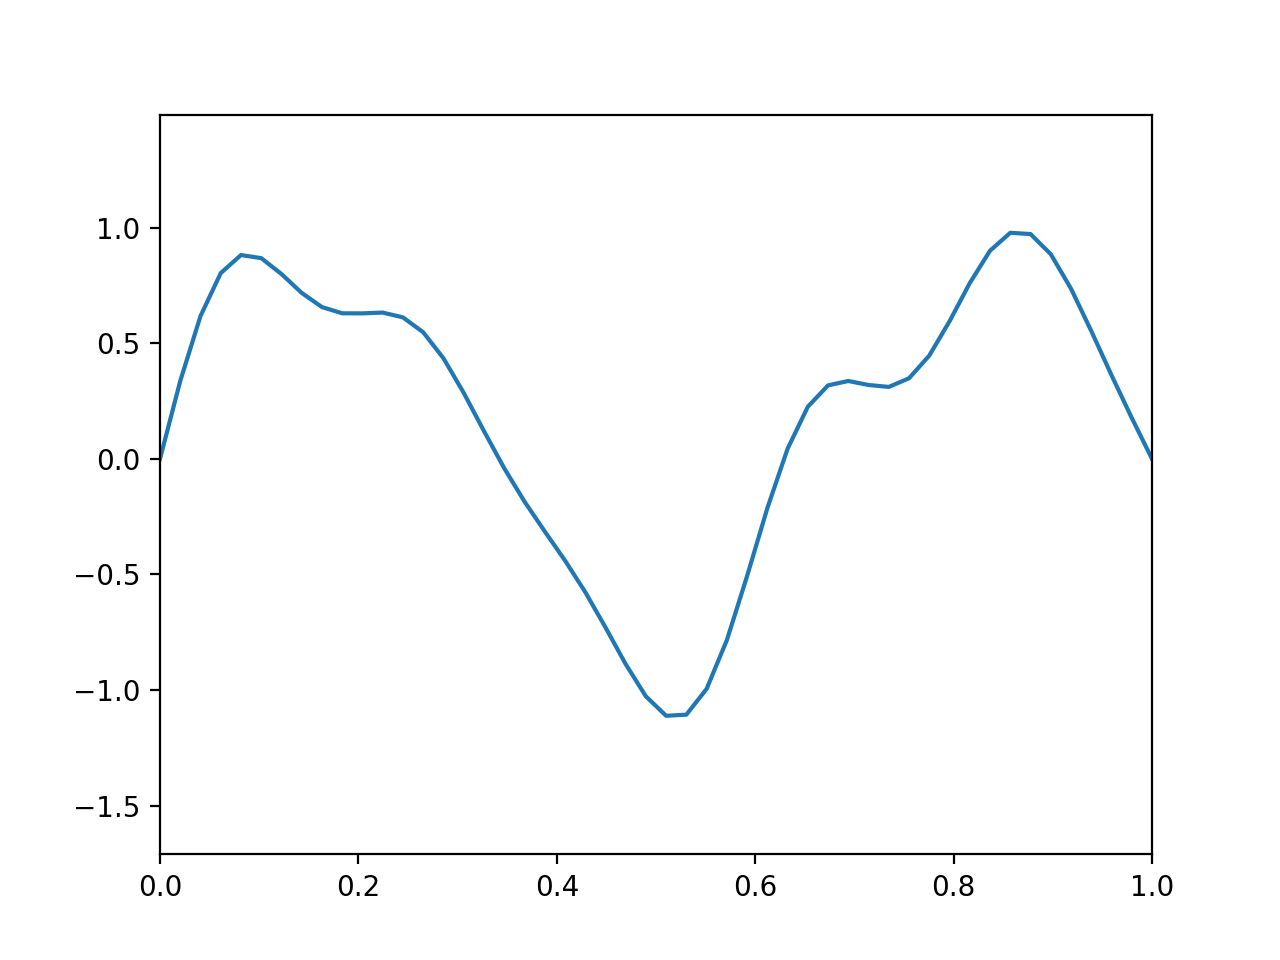

In [3]:
%matplotlib notebook

t_max = 1.0
t_min = 0.01
x_max = 1.
x_min = 0.
t_n = 50
x_n = 50

t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

u_true, cn = get_heat(t, x, [3, 7, 10], [0.7, 0.3, 0.4], 0.005)

outer_ani = animate_plot(u_true, x)

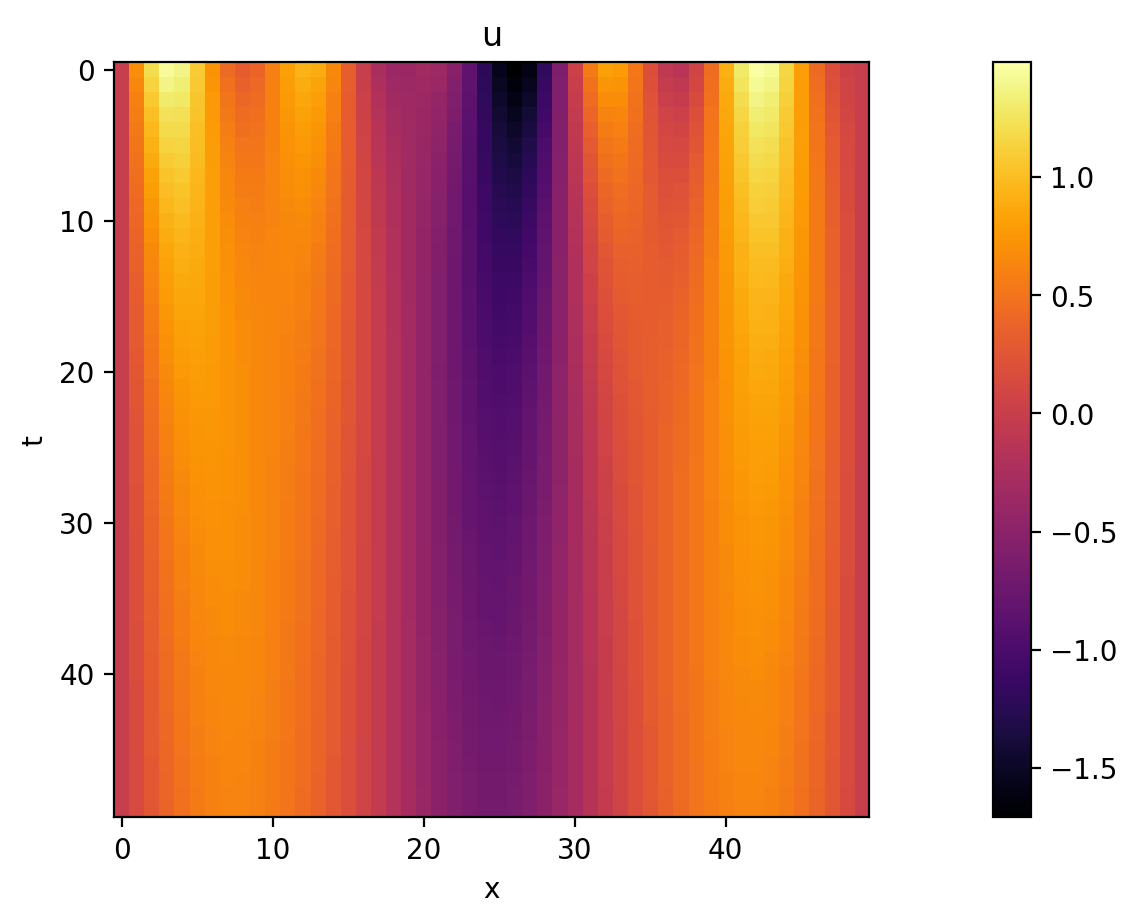

In [4]:
%matplotlib inline
show_state(u_true, 'u')

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well explicit, implicit finite-difference and finite-element solutions.

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with the implicit finite-difference, a numerically stable solution for a large range of parameters.

In [5]:
t_max = 1.0
t_min = 0.01
x_max = 1.
x_min = 0.
t_n = 64
x_n = 64

k = 0.005
c = [0.7, 0.3, 0.4]
n = [3, 7, 10]

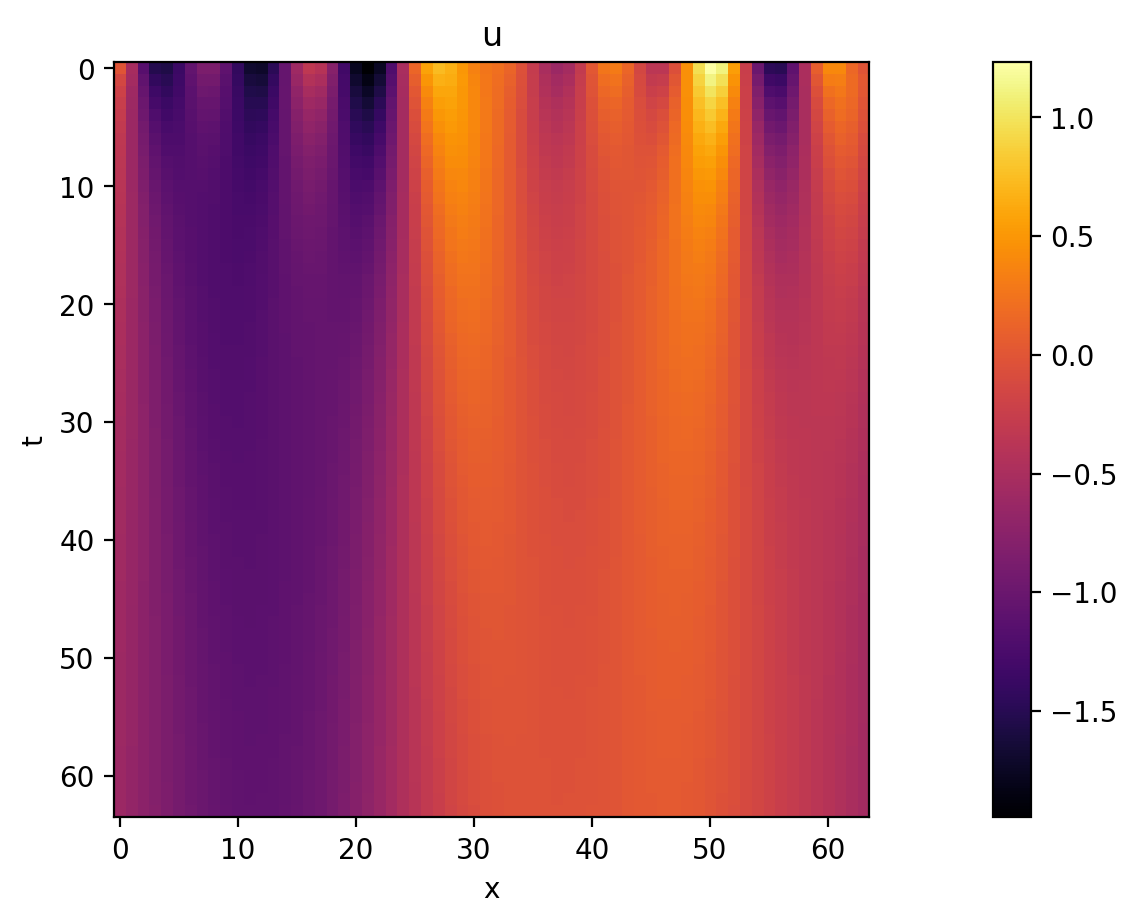

In [6]:
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

# u0 = heat_analytical_init(t, x, n, c)
# u0 = heat_analytical_init(t, x, list(range(1, 50)), [])
# u_fft = get_heat_fft(t, dx, x_n, k, u0)
# show_state(u_fft, 'u_fft')

u = heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, -1, 1, k)
show_state(u, 'u')

---

### Full-order model - Coarse grid

Several training datasets of high-dimension are generated, downsampled and compare to coarse grid solution as a point of comparison.

In [7]:
#training_set = generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 64, 1, k, './dataset/high_dim_init_training_set2.pt')
training_set = read_dataset('dataset/test.pt') # analytical_init_training_set

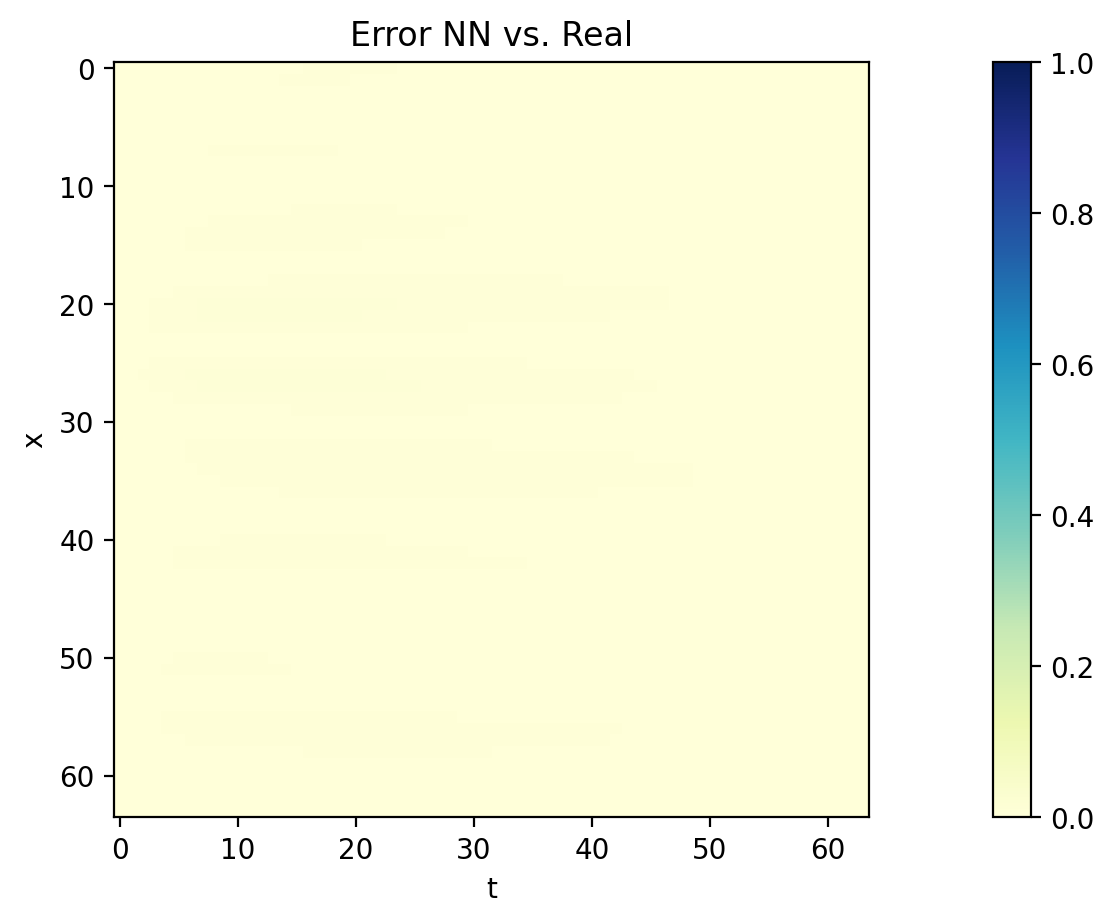

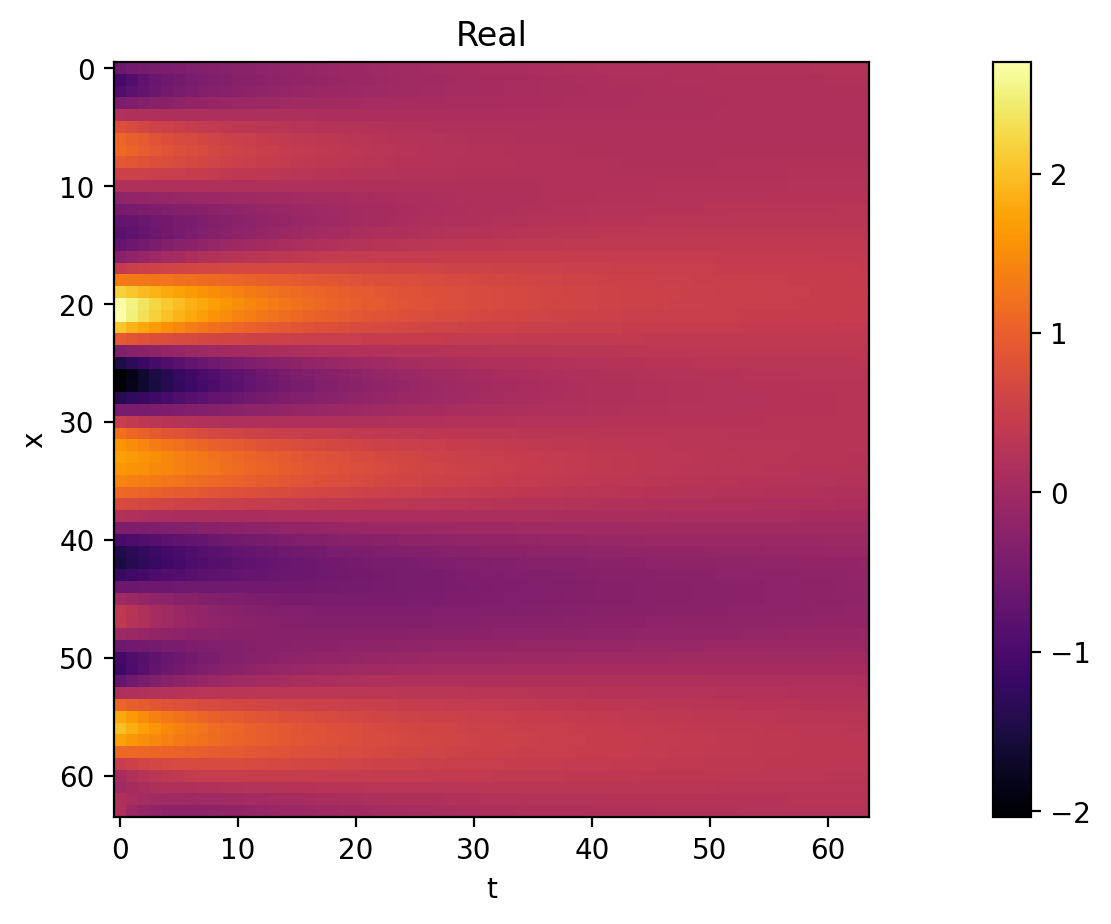

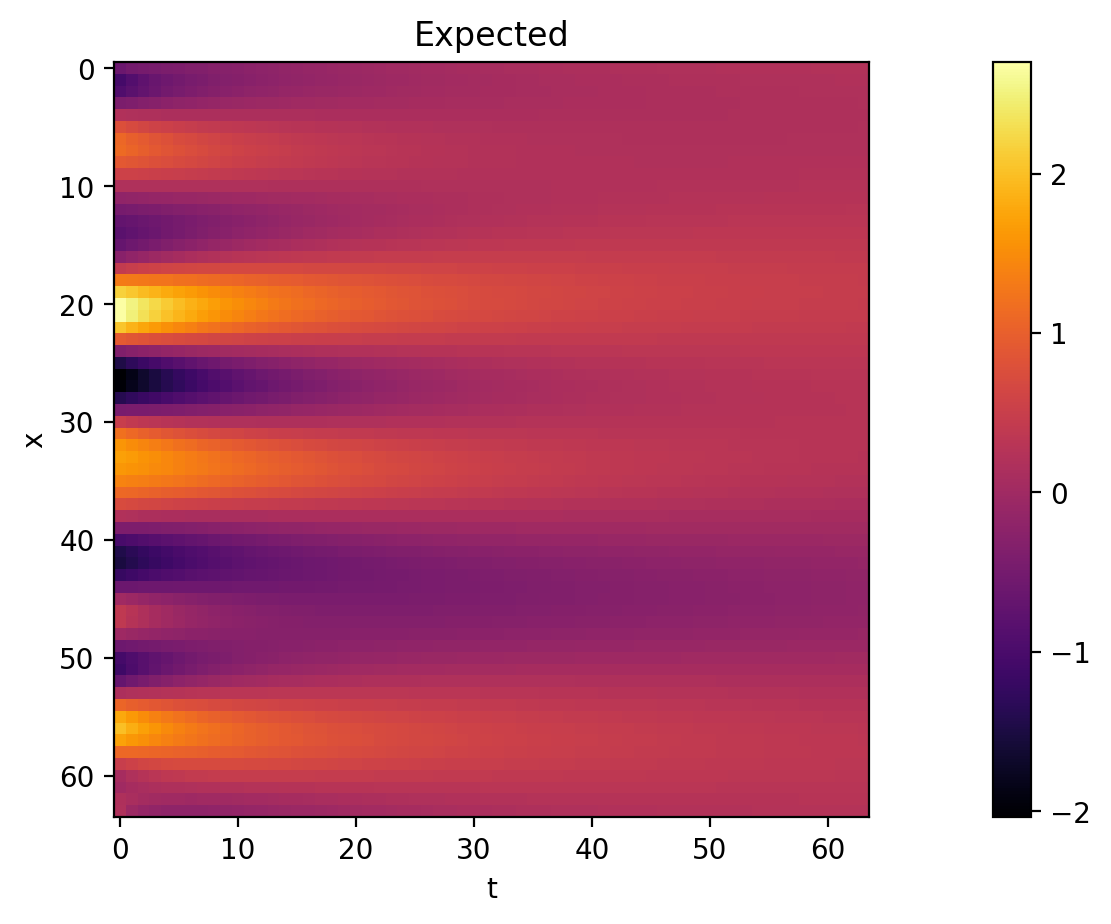

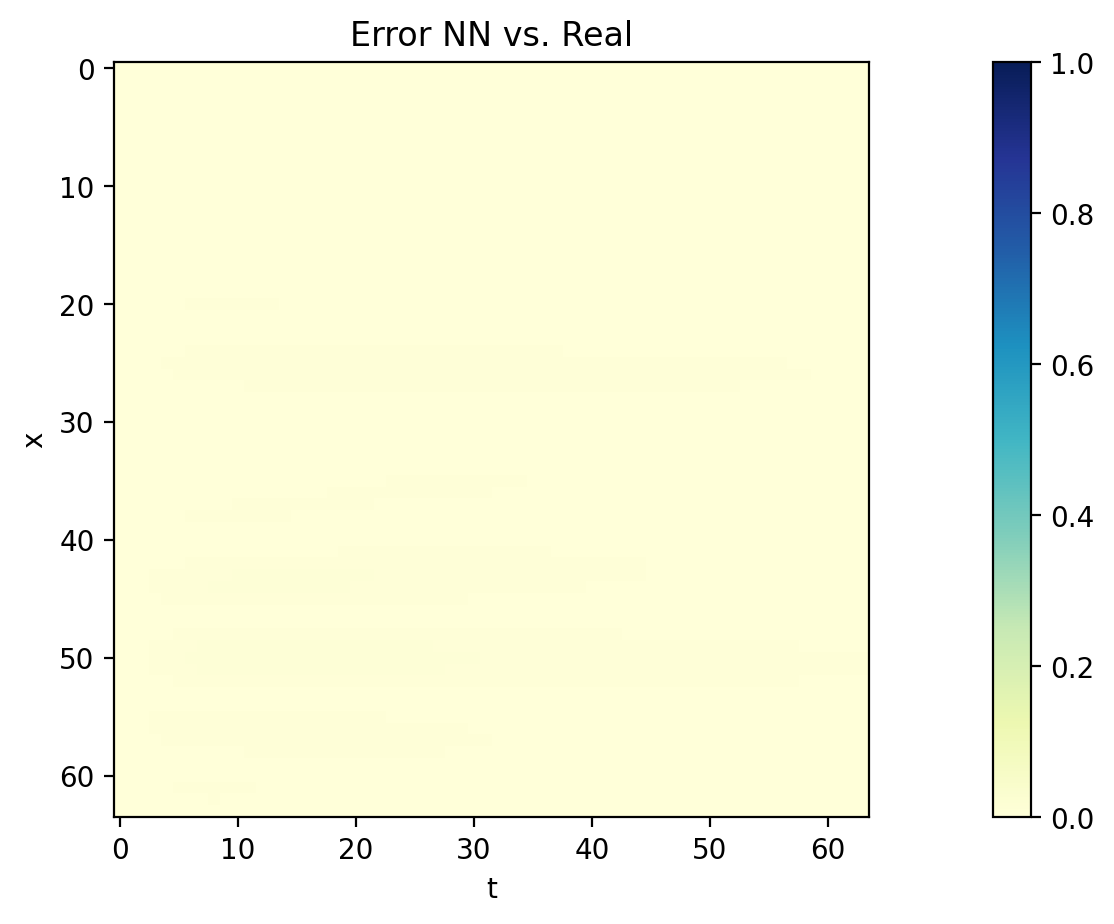

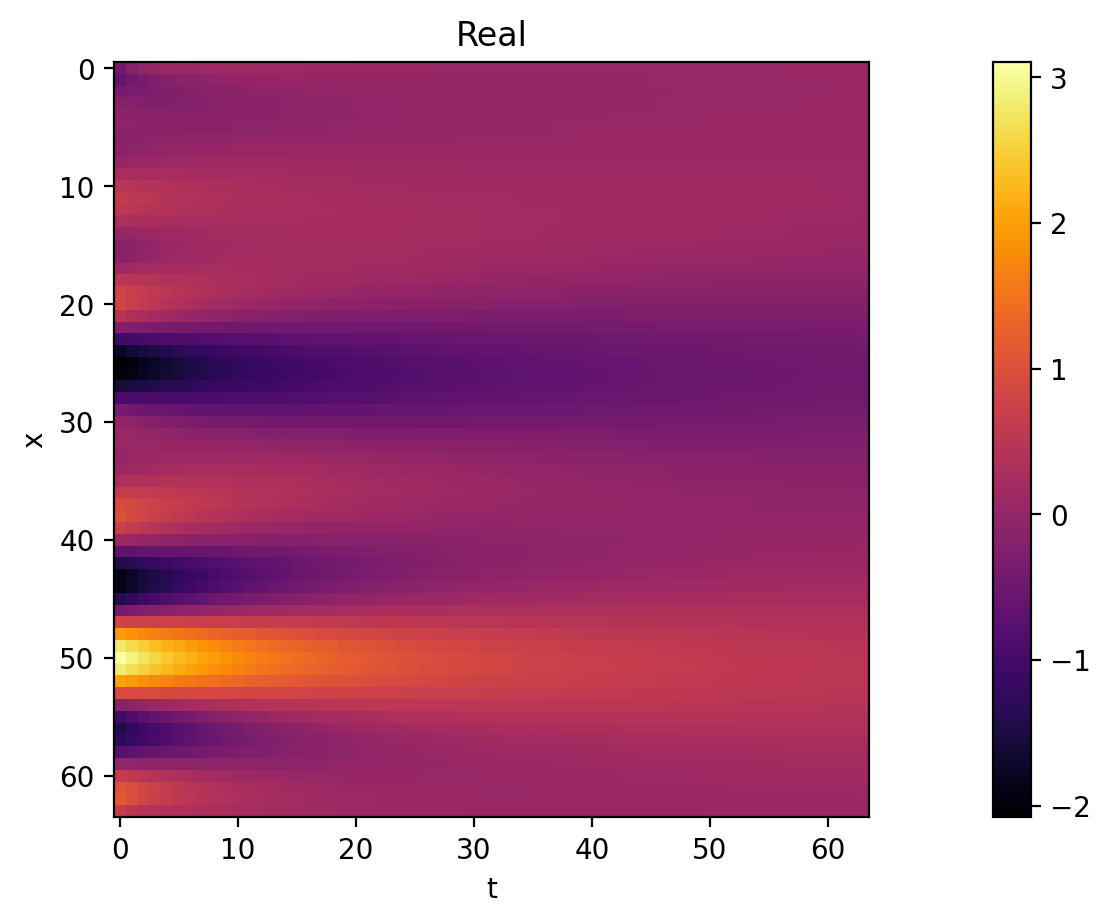

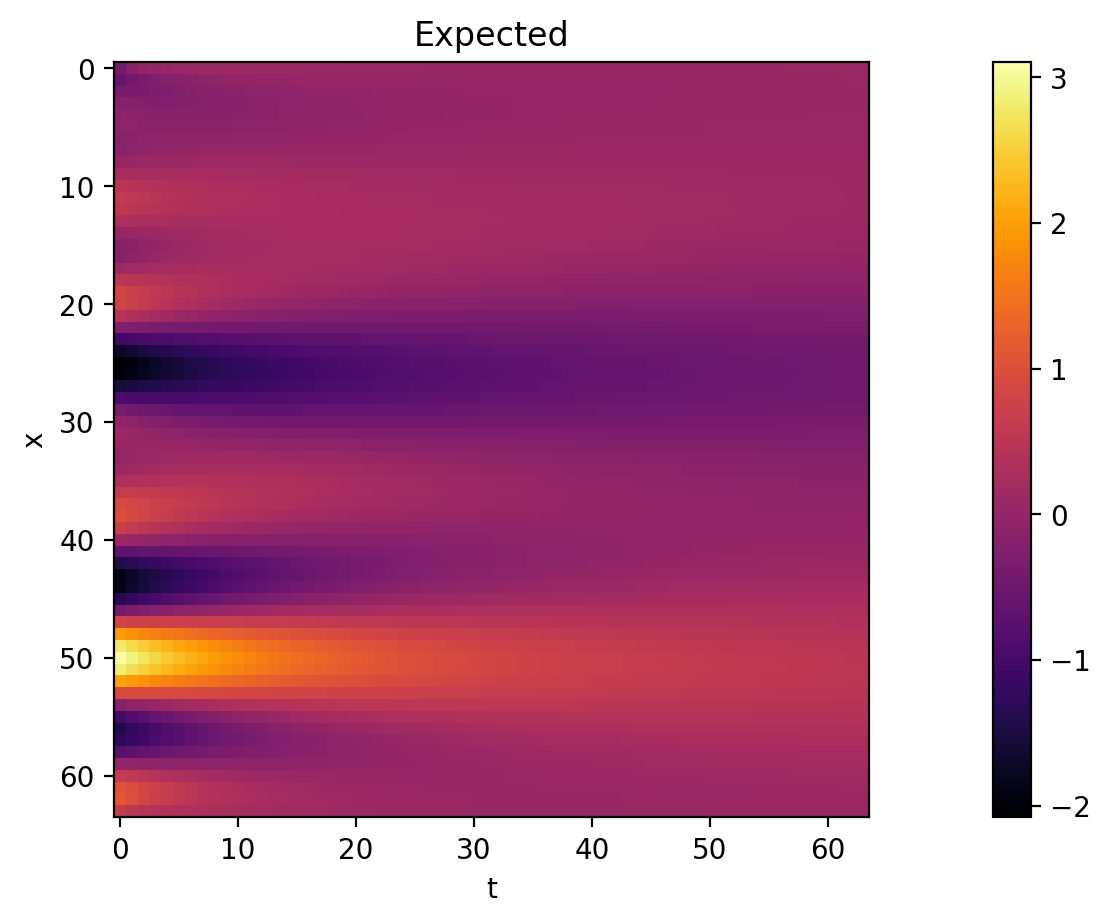

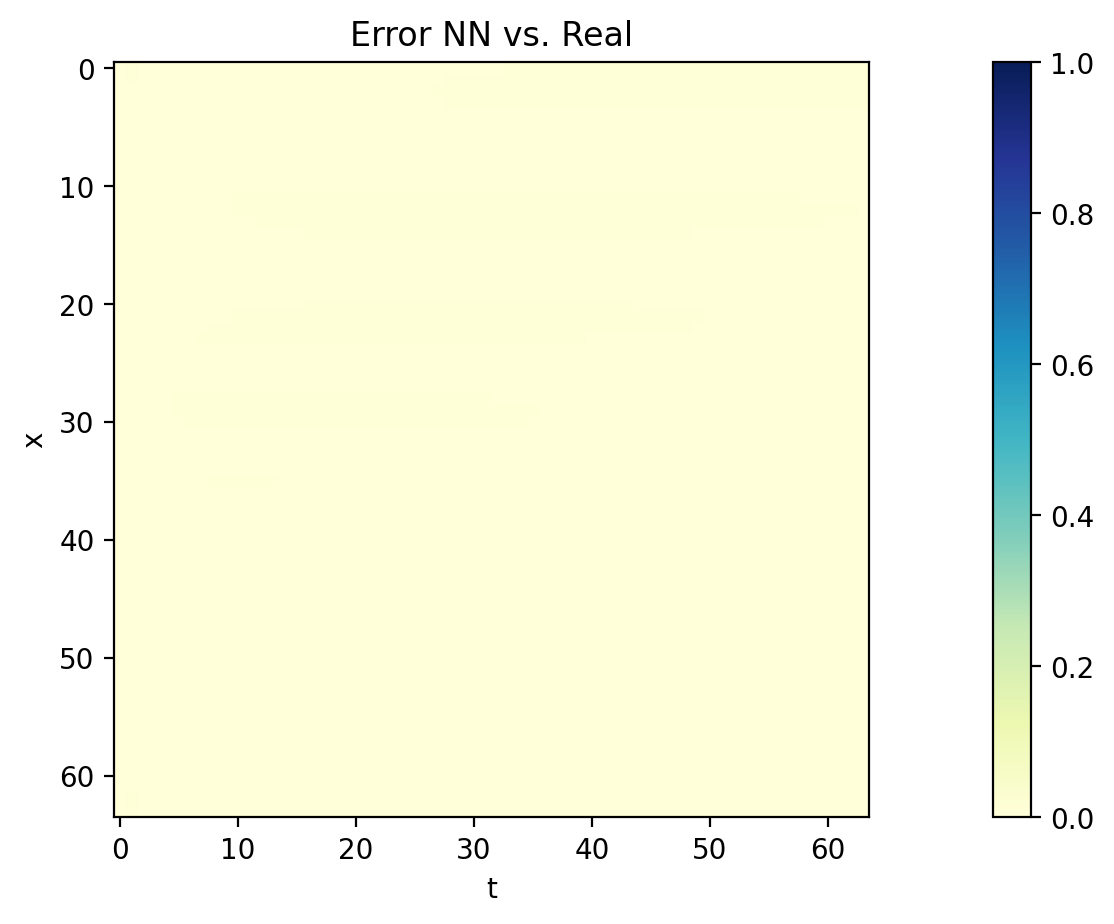

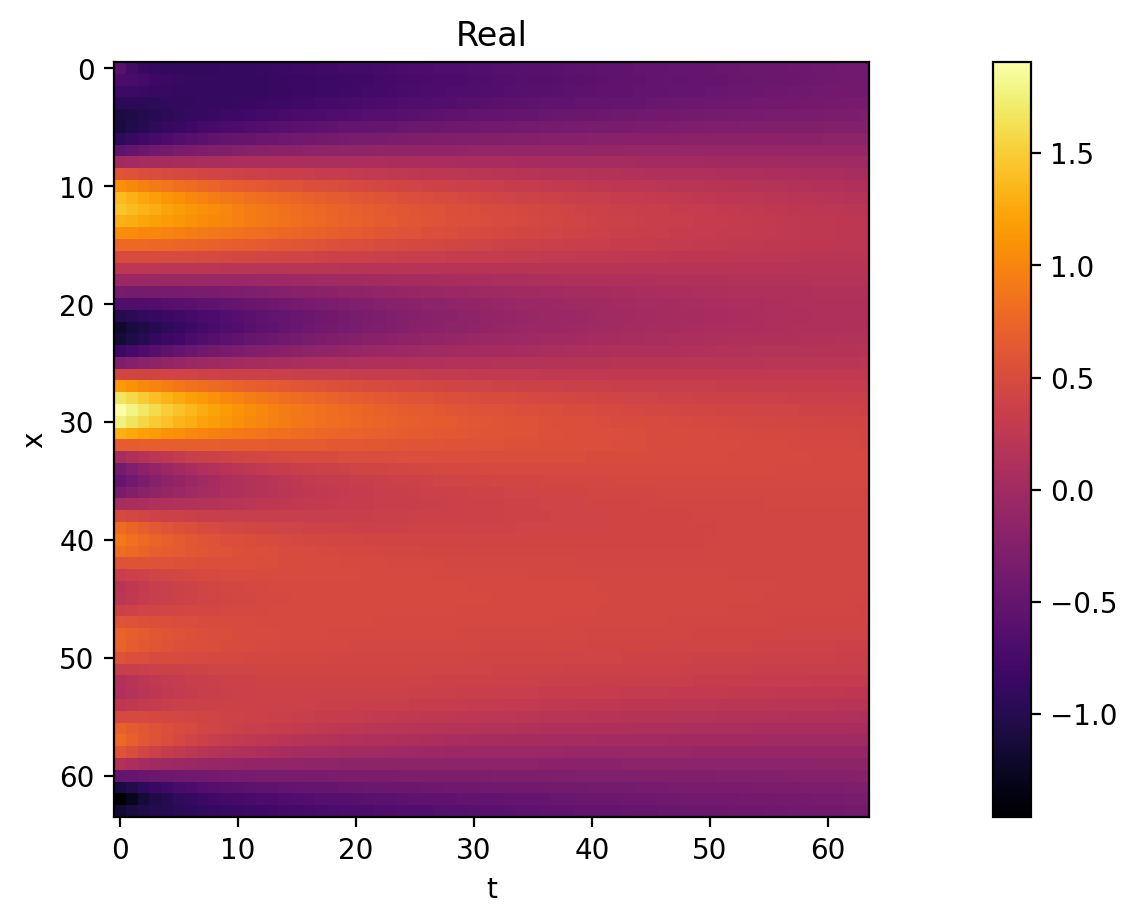

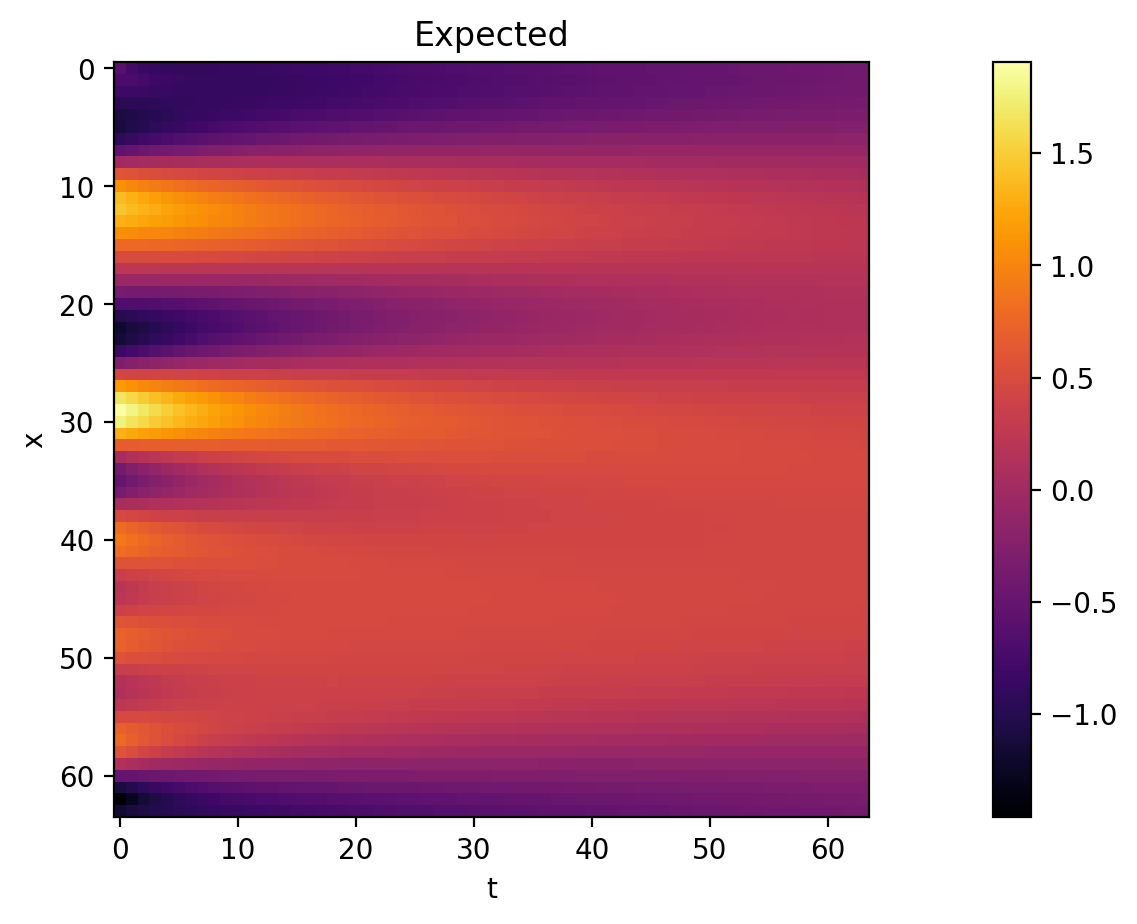

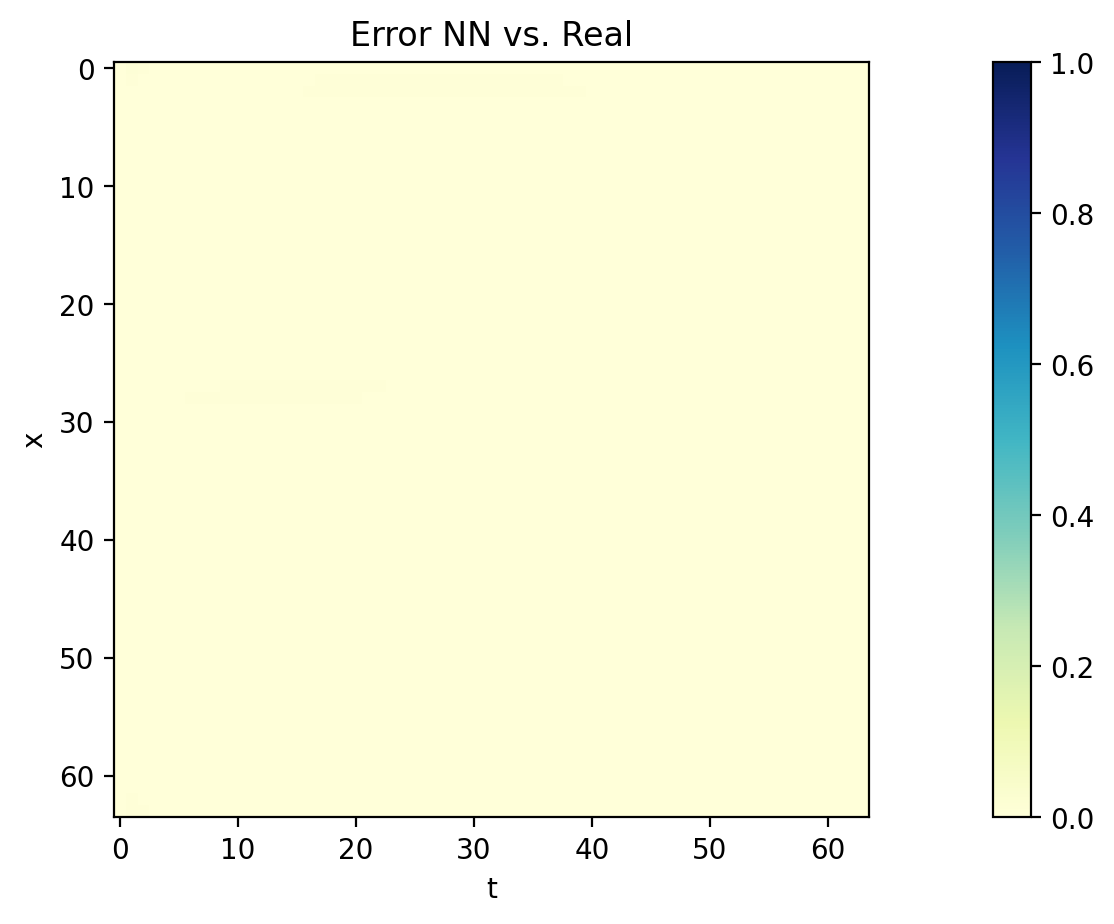

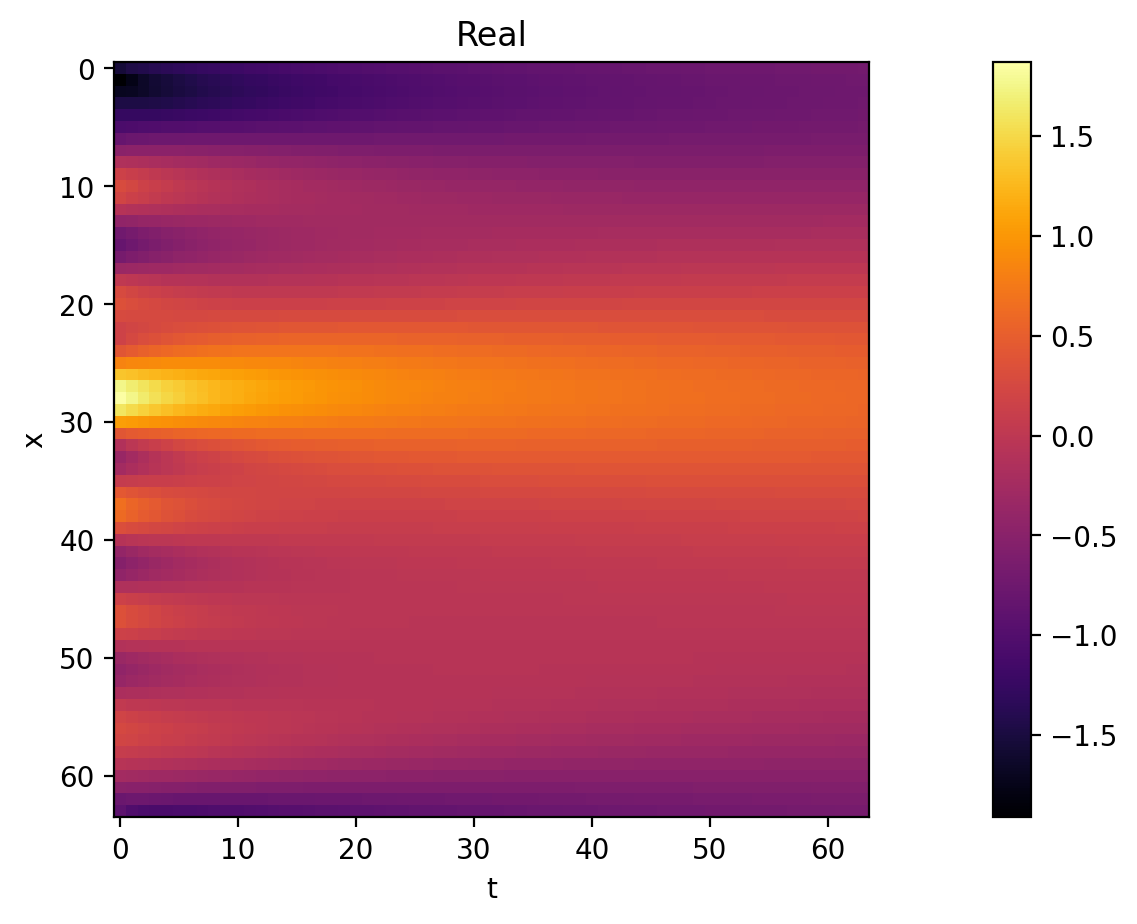

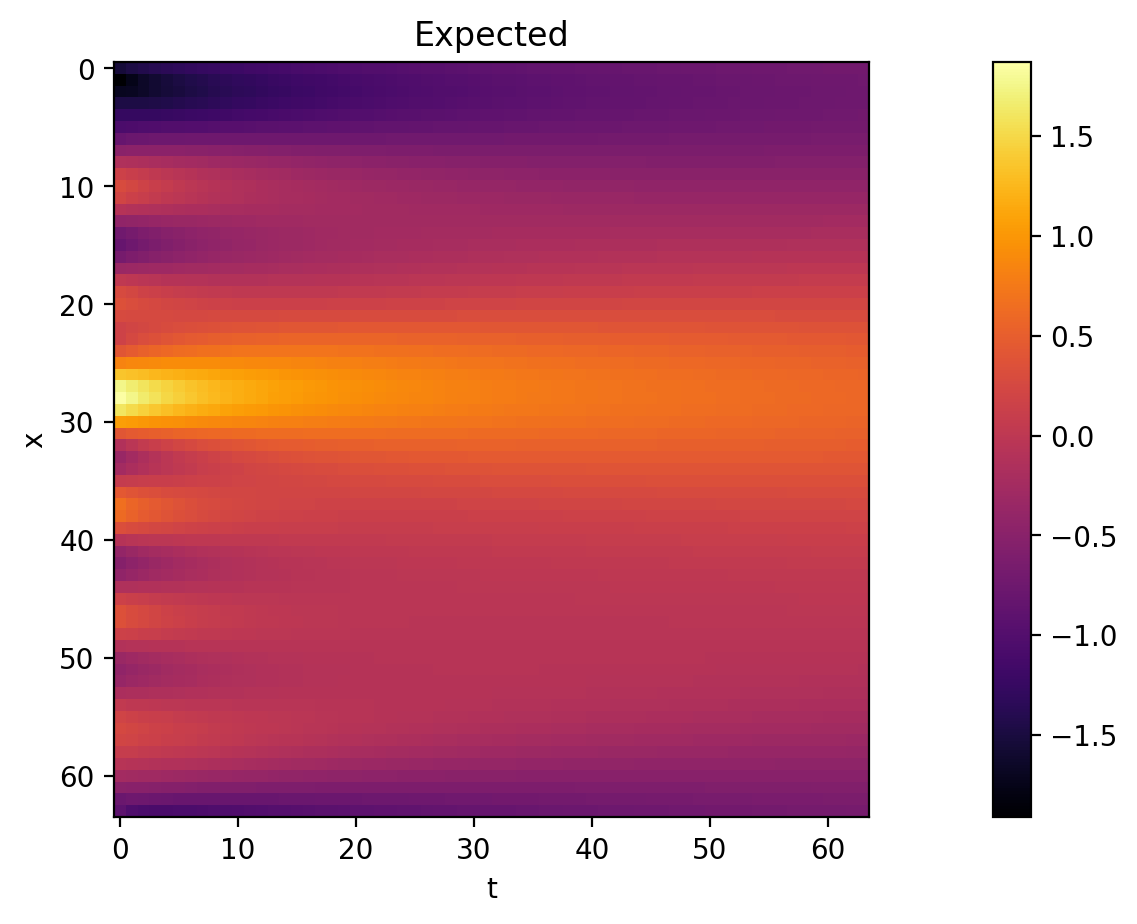

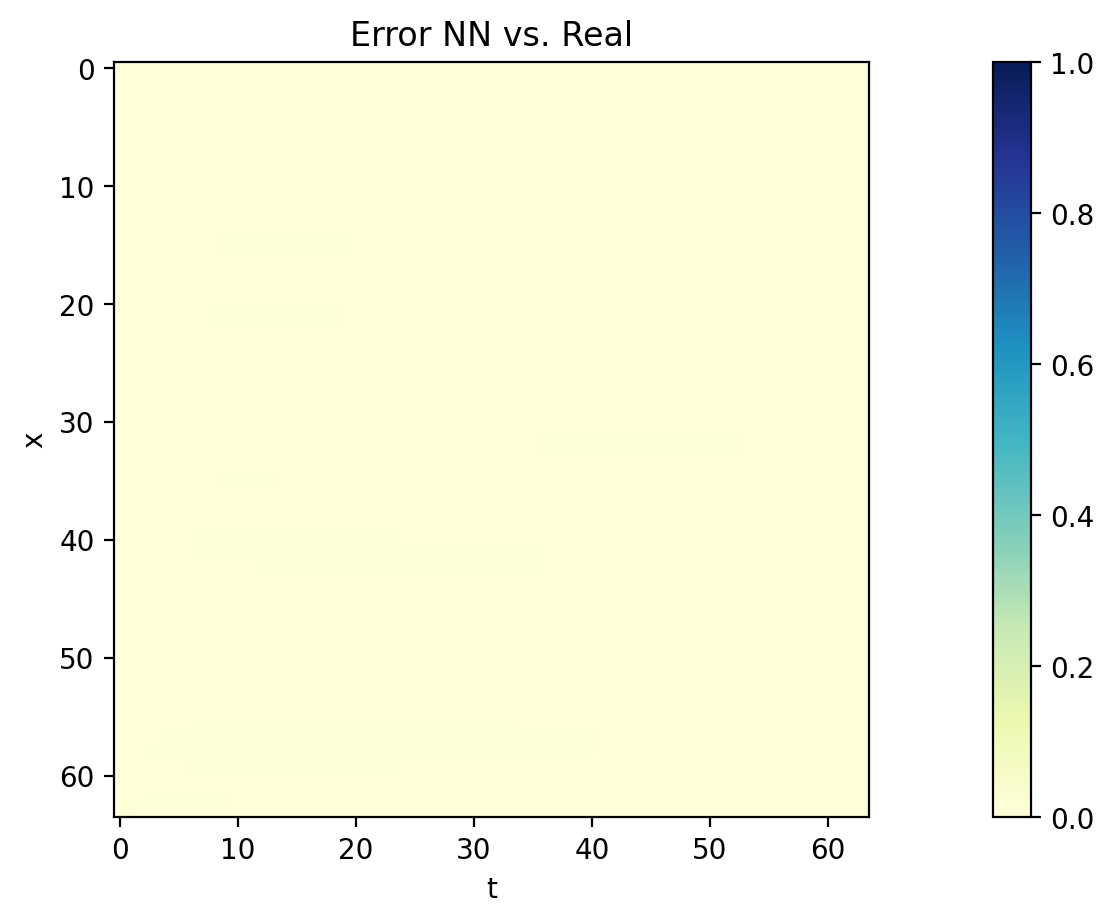

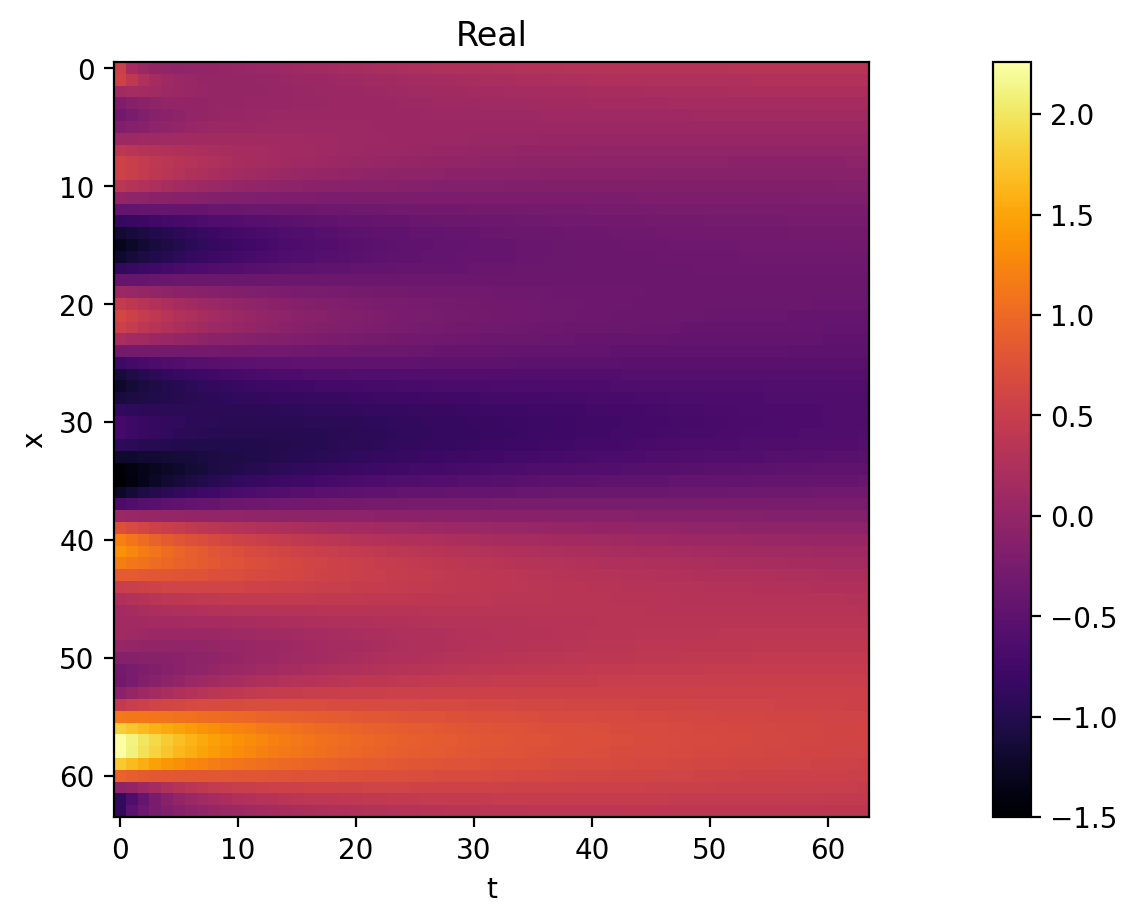

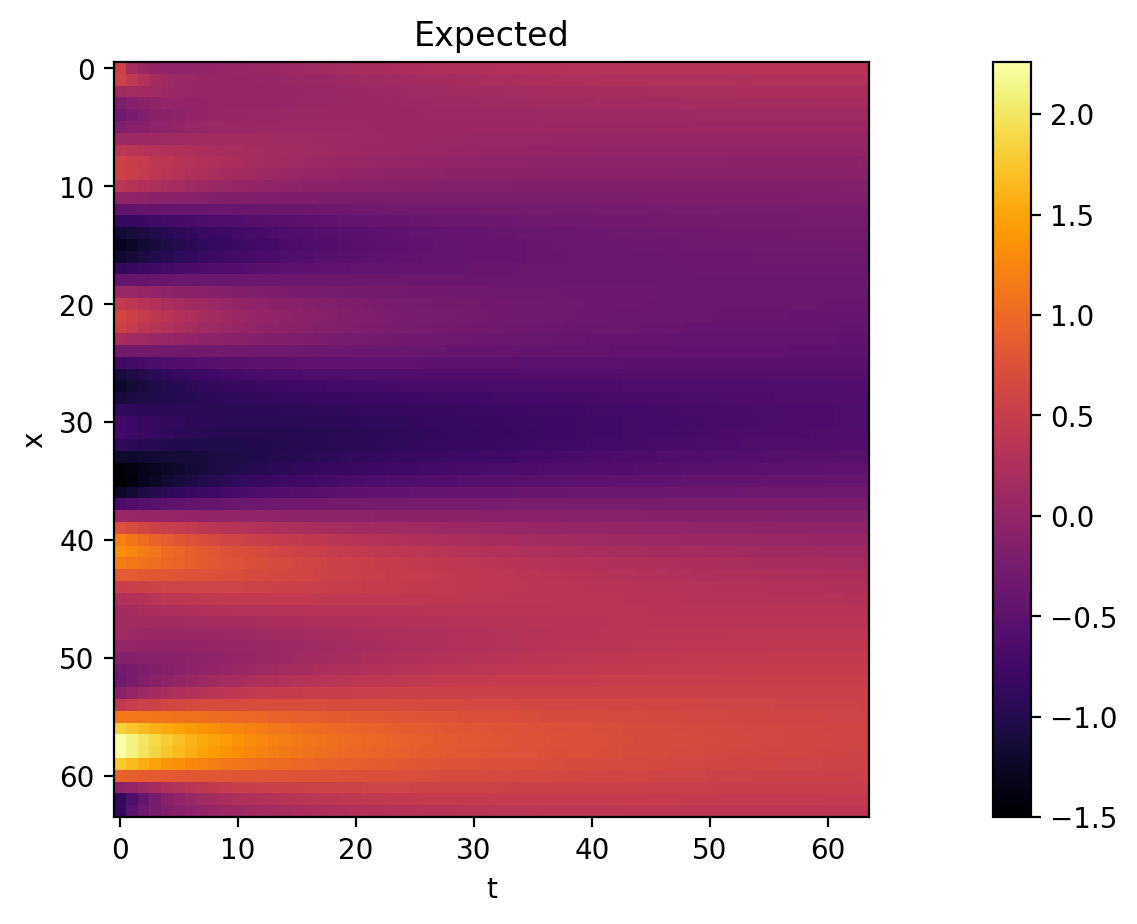

0.0001972942149412424
0.002723690704493727


In [8]:
def coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, dataset, show=False):
    batch_size = len(dataset)
    
    t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
    x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

    rmse_tot = 0
    re_tot = 0
    for i in range(batch_size):
        # Get downsize solution
        t, u, t2, _ = dataset[i]
        u = u.detach().numpy()
        
        # Generate coarse grid solution
        u0 = np.zeros((t_n, x_n))
        u0[0, :] = u[0, :]
        pred_u = get_heat_fft(t, dx, x_n, k, u0)
        #pred_u, _ = get_heat_fd_impl(dt, dx, t_n, x_n, u0)
        
        # Compute rmse and relative error
        re_tot += relative_err(u.T, pred_u.T)
        rmse_tot += rmse(pred_u.T, u.T)
        
        if show:
            show_err(np.abs(pred_u.T - u.T), 'Error NN vs. Real', 't', 'x', None)
            show_state(u.T, 'Real', 't', 'x', None)
            show_state(pred_u.T, 'Expected', 't', 'x', None)
    
    print(rmse_tot / batch_size)
    print(np.mean(re_tot) / batch_size)
    

coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, training_set, False)

---

## Operator F reconstruction

### Model used by ODE solver

Model registered in models.py under HeatModel name.

In [9]:
class ODEModel(nn.Module):
    def __init__(self, n):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, n, bias=False),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 0)
                # nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

In [10]:
def get_net(x_n):
    f = nn.Sequential(nn.Linear(x_n, x_n, bias=False))
    for m in f.modules():
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight, 0)
            #nn.init.normal_(m.weight, mean=0, std=0.2)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-5, rtol=1e-5, atol_adjoint=1e-5, rtol_adjoint=1e-5).to(device)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

Let's write a small training loop for our neural ode.

#### Training loop - ode solver & intrusive training

In [11]:
def loss_fn(pred_x, x):
    return nn.MSELoss(reduction='mean')(pred_x, x)

In [38]:
def training_ode_solver_net(net, epochs, t_n, x_n, dataset, val_epoch=10):
    optimizer = optim.Adam(net.parameters(), lr=0.003)
    training_batch_size = len(dataset)
    training_set_idx = np.arange(0, training_batch_size)
    
    tr_min_t = 0
    tr_max_t = int(len(dataset[0][0]) / 2)
    val_max_t = int(tr_max_t + len(dataset[0][0]) / 2)
    
    for e in range(1, epochs + 1):
        loss_tot = 0.
        val_loss_tot = 0.

        _, bu, _, _ = dataset[0]
        loss = loss_fn(bu.T, bu.T)
        
        # === Train ===
        net.train()
        np.random.shuffle(training_set_idx)
        for i in training_set_idx:
            t, bu, _, _ = dataset[i]
            tr_t =  t[tr_min_t:tr_max_t]
            tr_b0 = bu[tr_min_t, :]
            tr_bu = bu[tr_min_t:tr_max_t, :]
            #tr_t_eval, pred_u = net(tr_b0, tr_t)
            pred_u = odeint_adjoint(net, tr_b0, tr_t)
            
            # noise = torch.from_numpy(np.random.rand(tr_max_t - tr_min_t, x_n) * 1e-6).float()
            loss += loss_fn(pred_u, tr_bu) #+ 1e-5 * sum([torch.sum(p.pow(2.)) for p in net.parameters()])
            
        loss_tot += loss.item()
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        print('Epoch %d loss %f'%(e, loss_tot / float(training_batch_size)))
        
        # === Evaluate ===
        if (e > val_epoch):
            net.eval()
            with torch.no_grad():
                for j in training_set_idx:
                    t, bu, _, _ = dataset[j]
                    val_t = t[tr_max_t:]
                    val_b0 = bu[tr_max_t, :]
                    val_bu = bu[tr_max_t:, :]
                    val_pred_u = odeint_adjoint(net, tr_b0, tr_t)
                    val_loss = loss_fn(val_pred_u, val_bu)
                    val_loss_tot += val_loss.item()
                
                print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 1, k)
            # _, sample_pred = net(torch.from_numpy(sample_b0).float(), sample_t)
            sample_pred = odeint_adjoint(net, torch.from_numpy(sample_b0).float(), sample_t)
            show_state(sample_real.T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

Epoch 1 loss 0.271866
Epoch 2 loss 0.261863
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size(

Epoch 5 loss 0.235358
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([

Epoch 8 loss 0.213310
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([

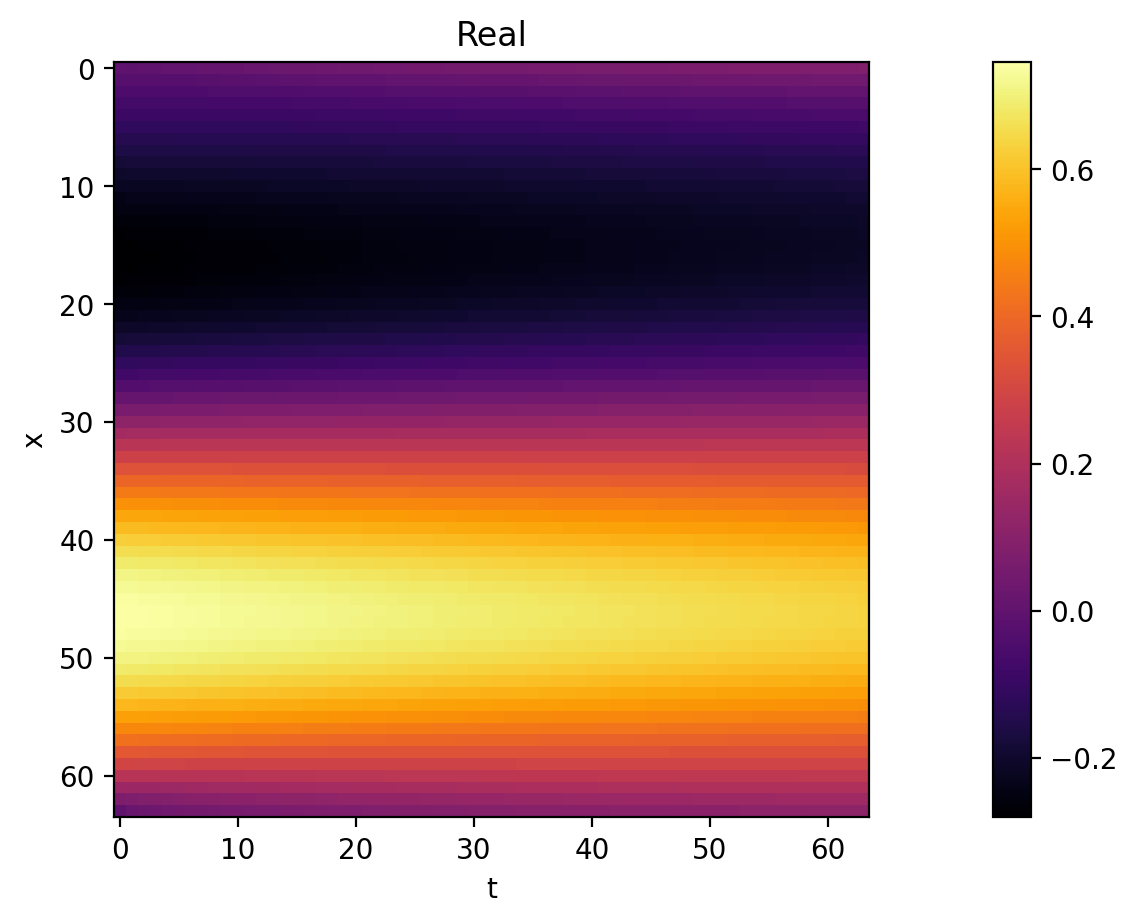

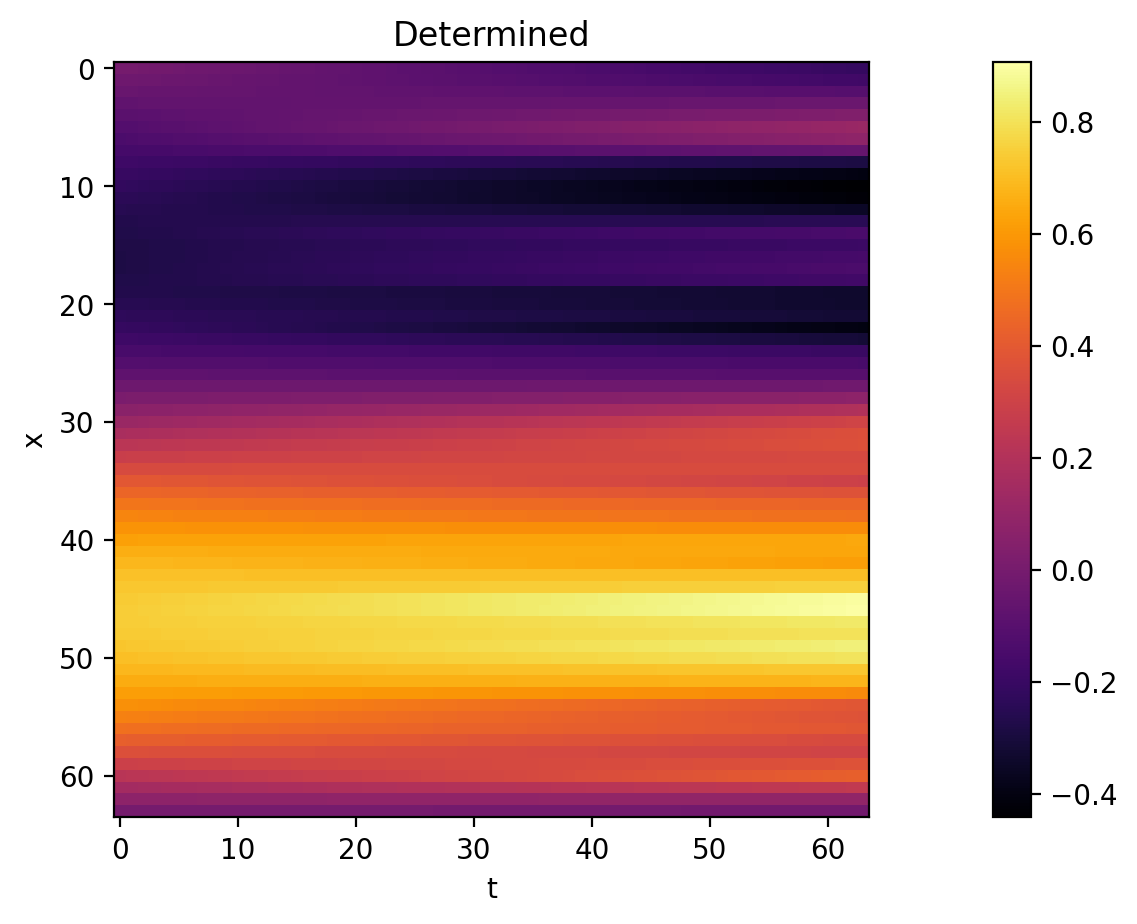

In [35]:
# net = get_net(x_n)
net = ODEModel(x_n)
F2 = training_ode_solver_net(net, 10, t_n, x_n, training_set, 1)

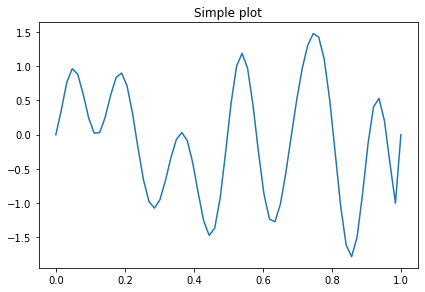

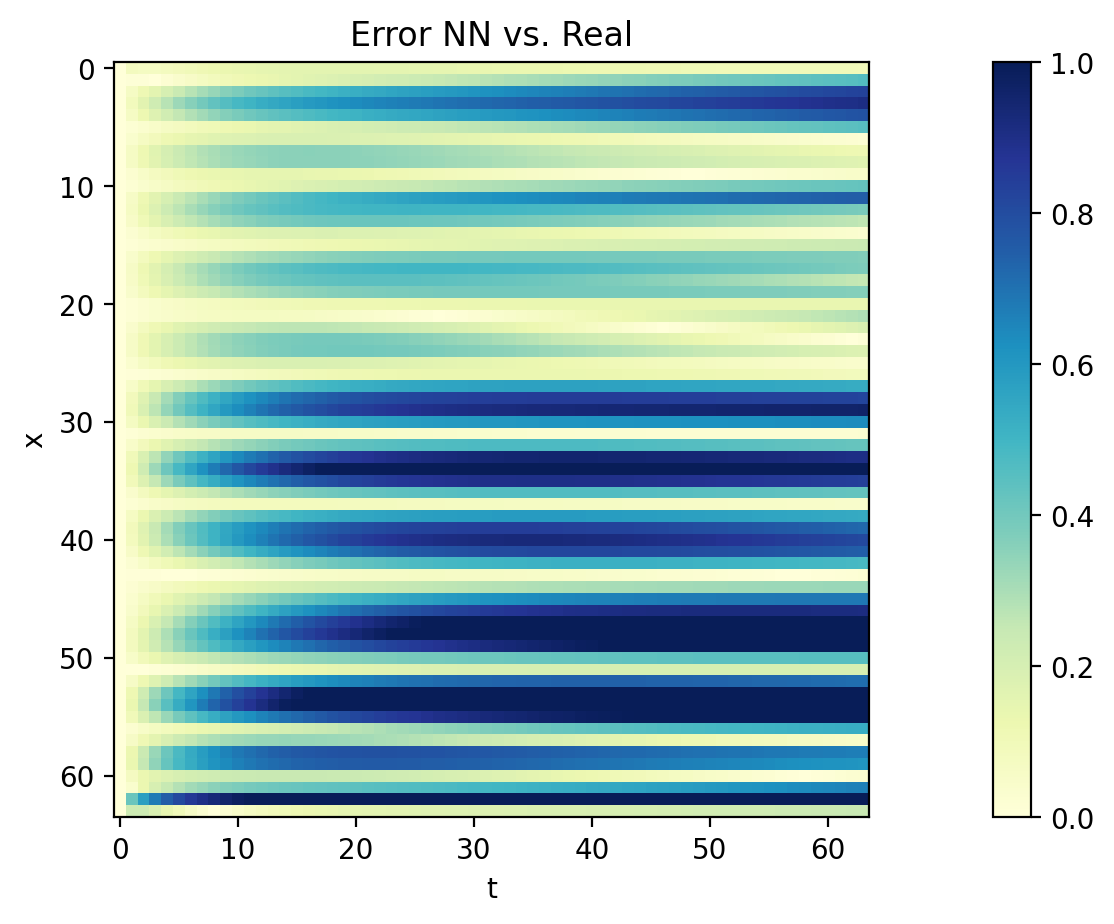

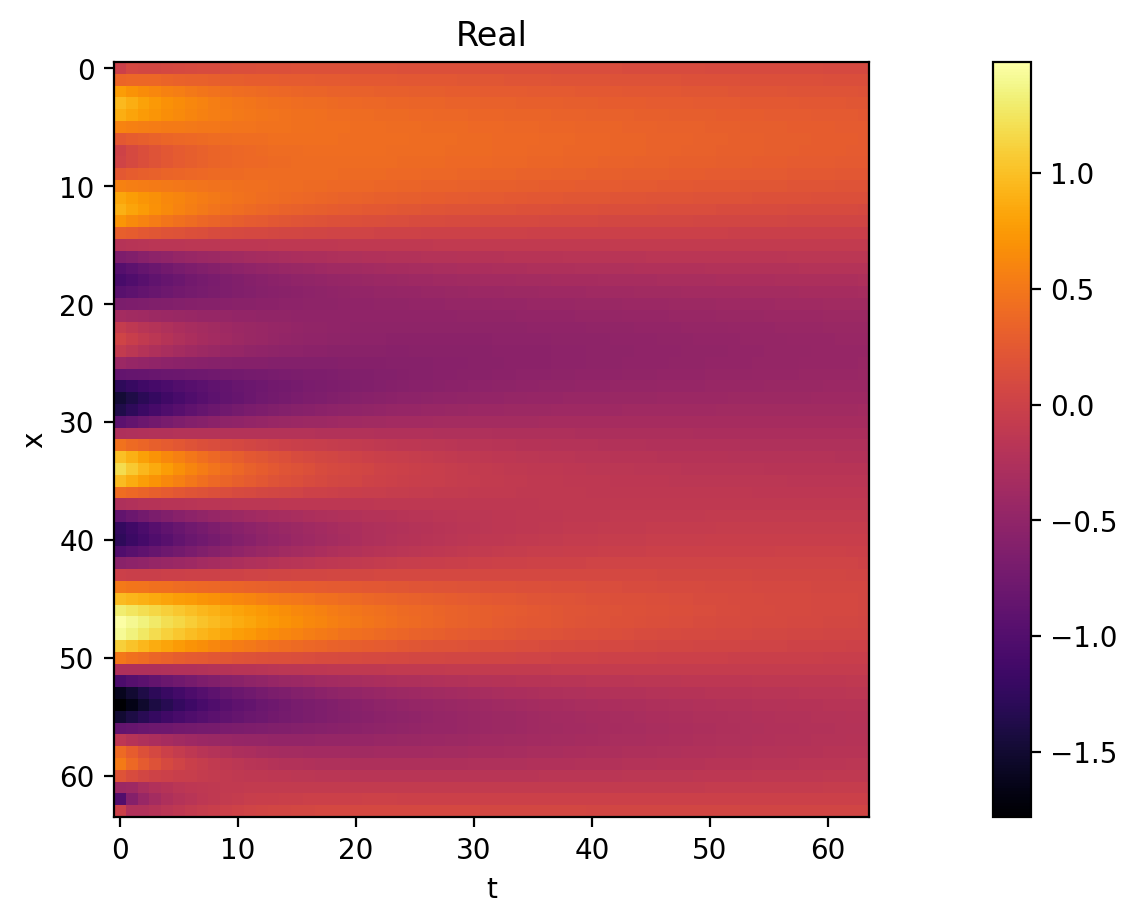

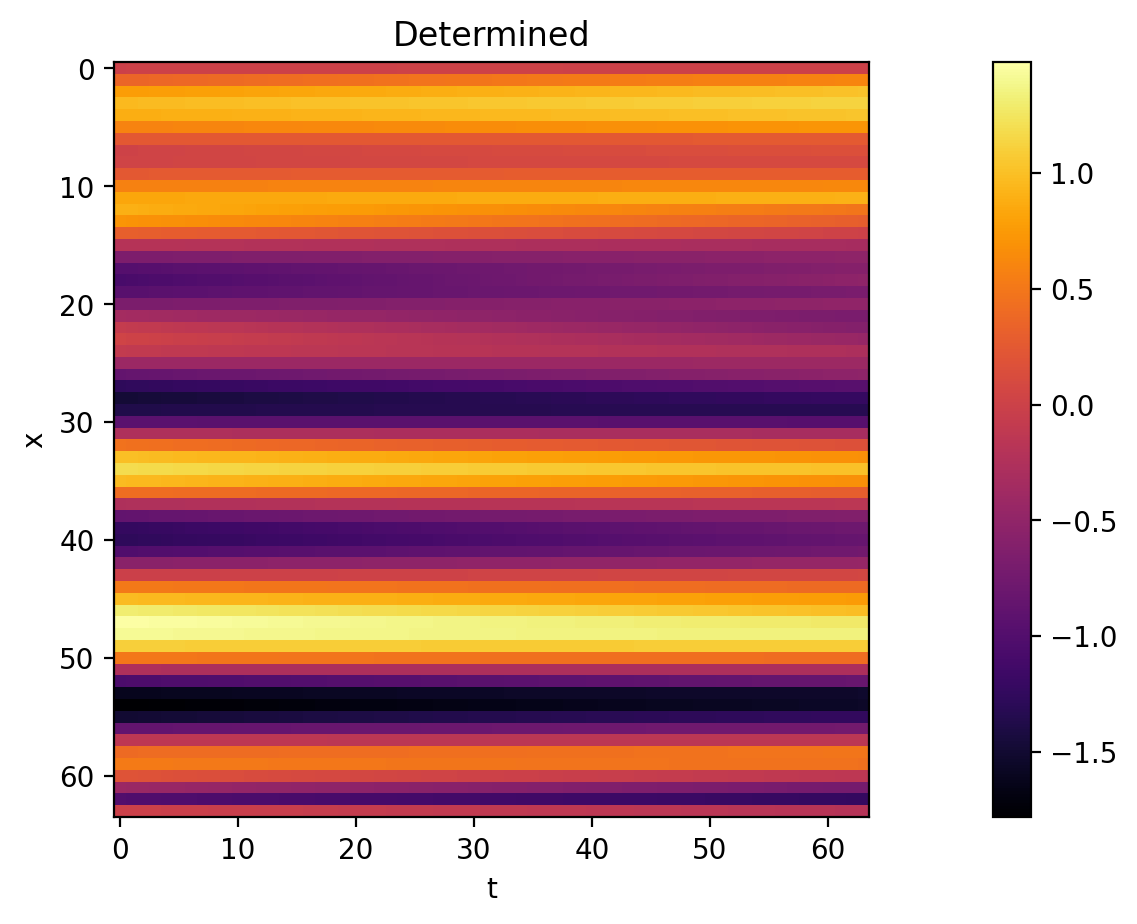

In [36]:
sample_t, sample_b0, sample_real = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 1, k)
sample_pred = odeint_adjoint(F2, torch.from_numpy(sample_b0).float(), sample_t)
simple_plotter([sample_b0])
show_err(np.abs(sample_pred.detach().numpy().T - sample_real.detach().numpy().T), 'Error NN vs. Real', 't', 'x', None)
show_state(sample_real.T, 'Real', 't', 'x', None)
show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)

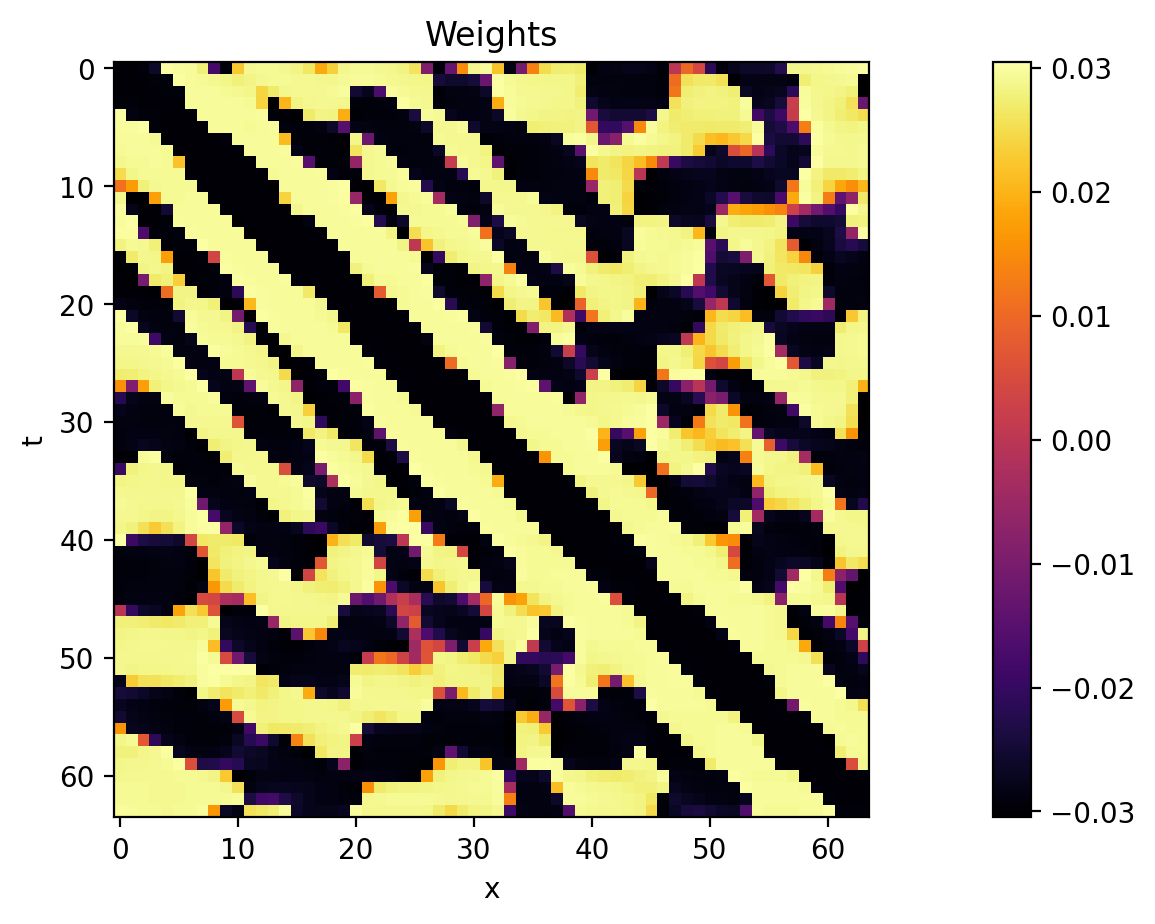

In [37]:
show_state(F2.net[0].weight.detach().numpy(), "Weights")

#### Training loop - derivative & non-intrusive training

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10, val_epoch=10, rand=-1):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        for i in range(batch_size):
            # === Randomness ====
            rand = -1
            if (i < len(rands))
                rand = rands[i]
            
            # === Train ===
            net.train()
            optimizer.zero_grad()
            
            t, b0, bu = get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_n, rand)
            dudt_ref = dudt(bu[:, 1:-1], (t_max - t_min) / t_n)
            pred_dudt = net([], bu[:-1, 1:-1])
            loss = loss_fn(pred_dudt.T, dudt_ref.T)
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()
            
            # === Evaluate ===
            if (e > val_epoch):
                net.eval()
                val_t, val_b0, val_bu = get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_n, rand)
                val_dudt_ref = dudt(val_bu[:, 1:-1], (t_max - t_min) / t_n)
                val_pred_dudt = net([], val_bu[:-1, 1:-1])
                val_loss = loss_fn(val_pred_dudt.T, val_dudt_ref.T)
                val_loss_tot += val_loss.item()
                
            
        if e % 10 == 0:
            print('Epoch %d loss %f'%(e, float(loss_tot / float(batch_size))))
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(batch_size))))
    
    return net

In [ ]:
%matplotlib inline
net2 = HeatModel(x_n)
F2 = training_ode_solver_net(net2, 300, t_n, x_n, 64, 5, False)

## Visualization

Let's train this basic NN and visualize its efficiency to match the solution u(t,x)

In [ ]:
def check_efficiency(net, n_sim=10, debug=False):
    rmse_tot = 0
    
    for i in range(n_sim):
        t, b0, u = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 2, k)
        _, pred_u = net(torch.from_numpy(b0).float(), t)
        rmse_tot += rmse(pred_u.detach().numpy(), u.detach().numpy())

        if debug:
            #double_plotter(pred_u.detach().numpy().T, u.detach().numpy().T, x_max, x_min, x_n, [8], 'Expected', 'Real', 'Expected vs. Real')
            show_err(np.abs(pred_u.detach().numpy().T - u.detach().numpy().T), 'Error NN vs. Real', 't', 'x', None)
            #show_state(u.detach().numpy().T, 'Real', 't', 'x', None)
            #show_state(pred_u.detach().numpy().T, 'Expected', 't', 'x', None)
    
    return rmse_tot / n_sim

print(check_efficiency(F, 10, True))

In [ ]:
check_weights(F)

---

## Proper orthogonal decomposition



In [ ]:
def pod(S, k_min=0, k_max=1):
    u, s, vh = np.linalg.svd(S.T, compute_uv=True)
    modes = u[:, k_min:k_max]
    return modes

In [ ]:
def pod_rom(S, dt, k_min=0, k_max=1):
    S_hat = np.fft.fft(S)
    S_hat_t = 1j * (2 * np.pi * np.fft.fftfreq(t_n, d=dt)) * S_hat
    S_t = np.fft.ifft(S_hat_t).real
    
    
    modes = pod(S, k_min, k_max)
    V = modes.T @ S
    V_t = modes.T @ S_t
    A_POD = V_t @ V.T / (V @ V.T + 1e-8)
    
    return A_POD.real

In [ ]:
def pod_rom_a(U, t_n, x_n, k_min=0, k_max=1):
    # Get covariance matrix
    C = np.matmul(U.T, U) # / X

    # Solve eigenproblem
    K, v = np.linalg.eigh(C)

    # Sort eigen values and vectors
    indexes = np.argsort(-abs(K))
    K = K[indexes] # eigenvalue
    v = v[:, indexes] # eigenvector = spatial mode

    # Compute time coefficient
    A = np.matmul(U, v.T);

    u_tilde = np.zeros((t_n, x_n))

    for k in range(k_min, k_max, 1):
        Vk = v[k, :]
        Vk = Vk[np.newaxis, :]
        Ak = A[:, k]
        Ak = Ak[:, np.newaxis]
        u_tilde_k = np.matmul(Ak, Vk)
        u_tilde += u_tilde_k#.detach().numpy()

    return u_tilde

In [ ]:
u0 = heat_analytical_init(t, x, n, c, k)
u = get_heat_fft(t, dx, x_n, k, u0)
A_pod = pod_rom(u, dt, 0, 20)

u_hat = pod_rom_a(u, t_n, x_n, 0, 20)

# fig, ax = plt.subplots(dpi=200)
# x = np.linspace(x_min, x_max, x_n)
# for k in [0, 1, 2]:
#     ax.plot(x, modes[:, k], label=k)
# plt.legend()
# plt.show()

# fig, ax2 = plt.subplots(dpi=200)
# ax2.matshow(modes@modes.T)
# plt.show()


In [ ]:
#u_tilde = pod_a(u[:, 1:-1], t_n, x_n, 0, 64)
#show_state(u_tilde, 'POD')

simple_plotter(u[0, 1:-1])

#### FOM

Coarse-grid resolution: 
- $t_{max} = 0.5$
- $x_{max} = 1.0$
- $t_n = 64$
- $x_n = 64$

#### Initial conditions


#### Boundary conditions

- Dirichlet: $u(t, a) = u(t, b) = 0, a <= x <= b$